In [19]:
# testing hysteresis parameter calculation? 
import numpy as np
import scipy.integrate as spi
from scipy.optimize import curve_fit
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib.collections as mcoll
import matplotlib.path as mpath

storm_directory = 'C:/Users/nicol/Documents/GitHub/La_Jara/Hysteresis/All_Summer_Storms'
storms = {}
for filename in os.listdir(storm_directory):
    # check if the file is a CSV file
    if filename.endswith('.csv'):
        file_path = os.path.join(storm_directory, filename) # construct the full file path
        df = pd.read_csv(file_path)                         # read the CSV file into a data frame
        df = df.dropna(subset=['Date_Time'])                # drop rows where 'Date/Time' is NaN  
        df['Date_Time'] = pd.to_datetime(df['Date_Time'])   # convert to datetime format
        df = df.set_index('Date_Time')                      # set date time as the index 
        df = df.dropna(how='all', axis=1)                   # drop columns where all values are NaN
        key = filename[:-4]                                 # remove the '.csv' from the filename to use as the dictionary key
        storms[key] = df                                    # store the data frame in the dictionary

## STORM 1 AS EXAMPLE ## 
SSC = storms['st1_down']['SS (uL/L)']
Q = storms['st1_down']['depth']
time = storms['st1_down'].index

In [20]:
# cleaner example data
Q = np.array([0, 10, 20, 30, 40, 35, 30, 25, 20, 15, 10, 5])  # Discharge
SSC = np.array([0, 5, 10, 15, 20, 18, 16, 14, 12, 8, 5, 2])  # SSC

In [21]:
def normalize_data(Q, SSC):
    Qn = Q / np.max(Q)  
    SSCn = SSC / np.max(SSC) 
    return Qn, SSCn

def find_rising_falling_limb(Qn, SSCn):
    Qmax_idx = np.argmax(Qn)  # Find the index of the maximum discharge (Qmax)

    # rising limb: including Qmax
    rising_Qn = Qn[:Qmax_idx+1]
    rising_SSCn = SSCn[:Qmax_idx+1]
    # falling limb: excluding Qmax
    falling_Qn = Qn[Qmax_idx:]
    falling_SSCn = SSCn[Qmax_idx:]
    return rising_Qn, rising_SSCn, falling_Qn, falling_SSCn

def distance_from_line(x, y, m, b):
    return np.abs(m * x - y + b) / np.sqrt(m**2 + 1)

In [23]:
# normalize discharge and SSC
Qn, SSCn = normalize_data(Q, SSC)
# find the rising and falling limbs
rising_Qn, rising_SSCn, falling_Qn, falling_SSCn = find_rising_falling_limb(Qn, SSCn)
# interpolate to get expected values along the rising and falling limbs
rising_SSC_interp = np.interp(Qn, rising_Qn, rising_SSCn)
falling_SSC_interp = np.interp(Qn, falling_Qn, falling_SSCn)

In [24]:
Qmax = np.max(Qn)
# Reference line from Qmax to the last point of the loop
reference_line_x = [Qmax, Qn[-1]]  # X-coordinates (discharge)
reference_line_y = [SSCn[np.argmax(Qn == Qmax)], SSCn[-1]]  # Y-coordinates (SSC)

# Calculate the slope (m) and intercept (b) of the reference line
m = (reference_line_y[1] - reference_line_y[0]) / (reference_line_x[1] - reference_line_x[0])
b = reference_line_y[0] - m * reference_line_x[0]

# Calculate perpendicular distances from each point in rising and falling limbs to the reference line
Drise = np.max([distance_from_line(rise_x, rise_y, m, b) for rise_x, rise_y in zip(rising_Qn, rising_SSCn)])
Dfall = np.max([distance_from_line(fall_x, fall_y, m, b) for fall_x, fall_y in zip(falling_Qn, falling_SSCn)])

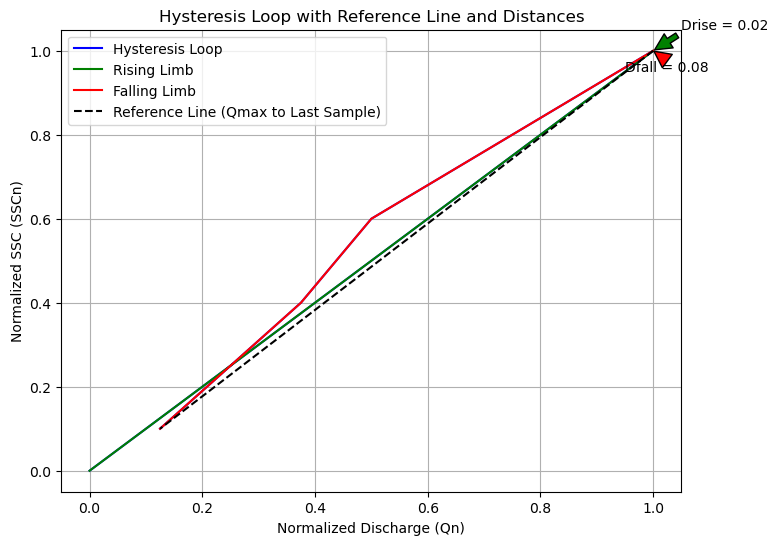

In [25]:
# Plot the hysteresis loop
plt.figure(figsize=(8, 6))
plt.plot(Qn, SSCn, label='Hysteresis Loop', color='b')
    
# Plot the rising and falling limbs
plt.plot(rising_Qn, rising_SSCn, label='Rising Limb', color='g')
plt.plot(falling_Qn, falling_SSCn, label='Falling Limb', color='r')

# Plot the reference line
plt.plot(reference_line_x, reference_line_y, '--k', label='Reference Line (Qmax to Last Sample)')

# Mark the Drise and Dfall distances
plt.annotate(f'Drise = {Drise:.2f}', xy=(rising_Qn[-1], rising_SSCn[-1]), xytext=(rising_Qn[-1]+0.05, rising_SSCn[-1]+0.05),
                arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(f'Dfall = {Dfall:.2f}', xy=(falling_Qn[0], falling_SSCn[0]), xytext=(falling_Qn[0]-0.05, falling_SSCn[0]-0.05),
                arrowprops=dict(facecolor='red', shrink=0.05))

plt.xlabel('Normalized Discharge (Qn)')
plt.ylabel('Normalized SSC (SSCn)')
plt.title('Hysteresis Loop with Reference Line and Distances')
plt.legend()
plt.grid(True)
plt.show()